<a href="https://colab.research.google.com/github/susumu2357/US-patent-analysis/blob/master/colab/w2v_claim_background_IPC_tripletloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

import multiprocessing
CPUNUM = multiprocessing.cpu_count()

In [0]:
!mkdir -p ./data

!gsutil cp gs://mlstudy-phys/data/grants_for_3000+3000.df.gz ./data/ 
!gsutil cp gs://mlstudy-phys/data/testset_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/training_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./data/ 

Copying gs://mlstudy-phys/data/grants_for_3000+3000.df.gz...
\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    
Copying gs://mlstudy-phys/data/testset_app_3000.df.gz...
- [1 files][ 45.5 MiB/ 45.5 MiB]                                                
Operation completed over 1 objects/45.5 MiB.                                     
Copying gs://mlstudy-phys/data/training_app_3000.df.gz...
- [1 files][ 45.0 MiB/ 45.0 MiB]                                                
Operation completed over 1 objects/45.0 MiB.                                     
Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    


In [0]:
grants = pd.read_pickle("./data/grants_for_3000+3000.df.gz")
test_app = pd.read_pickle("./data/testset_app_3000.df.gz")
train_app = pd.read_pickle("./data/training_app_3000.df.gz")
citations = pd.read_pickle("./data/citations_info_3000+3000.df.gz")

citations = citations[citations["action_type"] == 102]
cite_app = citations["app_id"]
cite_grant = citations ["parsed"]
cite_relation = pd.concat([cite_app, cite_grant], axis=1)

In [0]:
import re
CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)
TAG_PAT = re.compile(r"<.*?>")
LB_PAT = re.compile(r'[\t\n\r\f\v][" "]*')
CANCELED_PAT = re.compile(r'[0-9]+.*\. \(canceled\)[" "]')
NUM_PAT = re.compile(r'[" "]?[0-9]+[" "]?\.[" "]?')

def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

def remove_linebreak_from_claim(claim):
    '''
    Remove line break symbol "\n" with space(s).
    '''
    return LB_PAT.sub('', claim)

def remove_canceled_claim(claim):
    return CANCELED_PAT.sub('', claim)
  
def remove_claim_numbers(claim):
    return NUM_PAT.sub('', claim)  

In [0]:
grants["claim_cited_grant"] = grants["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)
test_app["claim_app"] = test_app["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)
train_app["claim_app"] = train_app["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)

In [0]:
import re
BACKGROUND_TO_SUMMARY = re.compile(r'<\?summary-of-invention[^>]*>(.*)<\?summary-of-invention[^>]*>',re.MULTILINE|re.DOTALL)
BACKGROUND_TO_SUMMARY_GRANT = re.compile(r'<\?BRFSUM[^>]*>(.*)<\?BRFSUM[^>]*>',re.MULTILINE|re.DOTALL)

TAG_PAT = re.compile(r"<.*?>")
LB_PAT = re.compile(r'[\t\n\r\f\v][" "]*')

def whole_xml_to_background_xml(whole):
    mat = BACKGROUND_TO_SUMMARY.search(whole)
    if mat is None:
      return ""
    else:
      return mat.group(1)
  
def whole_xml_to_background(whole):
    return TAG_PAT.sub(' ', whole_xml_to_background_xml(whole))

def whole_xml_to_background_xml_grant(whole):
    mat = BACKGROUND_TO_SUMMARY_GRANT.search(whole)
    if mat is None:
      return ""
    else:
      return mat.group(1)
  
def whole_xml_to_background_grant(whole):
    return TAG_PAT.sub(' ', whole_xml_to_background_xml_grant(whole))

def remove_linebreak_from_claim(claim):
    '''
    Remove line break symbol "\n" with space(s).
    '''
    return LB_PAT.sub('', claim)

In [0]:
train_app["background"] = train_app["xml"].map(whole_xml_to_background).map(remove_linebreak_from_claim)
test_app["background"] = test_app["xml"].map(whole_xml_to_background).map(remove_linebreak_from_claim)
grants["background"] = grants["xml"].map(whole_xml_to_background_grant).map(remove_linebreak_from_claim)

In [0]:
grants = grants.drop("xml" ,axis=1)
grants.head()

,parsed,claim_cited_grant,background
0,6837113,A method for determining an estimated velocity...,CROSS-REFERENCE TO RELATED APPLICATIONS Not Ap...
1,6837224,An evaporated fuel treatment device for intern...,BACKGROUND OF THE INVENTION 1. Field of the In...
2,6837699,An apparatus for clamping used in molding appl...,BACKGROUND OF THE INVENTION 1) Field of the In...
3,6837886,"A system, comprising:a catheter having a braid...",BACKGROUND OF THE INVENTION 1. Field of the In...
4,6837901,The method of delivering a shape memory stent ...,FIELD OF THE INVENTION The present invention g...


In [0]:
test_app = test_app.drop("xml" ,axis=1)
test_app.head()

,app_id,claim_app,background
0,12211548,A method for ranking an entity against a group...,FIELD OF THE INVENTION The present invention r...
1,12765236,A dental composition comprising:(1) at least o...,The field of the invention is that of dental c...
2,12827269,"A vehicle, comprising:a chassis; a platform su...",TECHNICAL FIELD Embodiments of the present inv...
3,14436491,A conjugate comprising a GM-CSF polypeptide an...,BACKGROUND Cancer is thought to occur as a res...
4,13633425,"A method for manufacturing a stack package, co...",CROSS-REFERENCE TO RELATED APPLICATIONS The pr...


In [0]:
train_app = train_app.drop("xml" ,axis=1)
train_app.head()

,app_id,claim_app,background
0,12130785,A system for differentiating noise from an arr...,FIELD OF THE INVENTION The present disclosure ...
1,12652424,A method of allocating resources in a data war...,BACKGROUND An organization may store data in a...
2,12214532,A controlling method of a media processing app...,The disclosure of Japanese Patent Application ...
3,14204411,An electronic percussion instrument comprising...,BACKGROUND OF THE INVENTION 1. Field of the In...
4,13090122,A composition comprising at least one active a...,FIELD OF THE INVENTION The present invention e...


In [0]:
grants["background"][grants["background"] == ""].index

Int64Index([2309], dtype='int64')

In [0]:
grants["background"][2309] = "background of the invention"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
claim_app_list = train_app['claim_app'].map(lambda x:x.split()).tolist()
claim_grant_list = grants['claim_cited_grant'].map(lambda x:x.split()).tolist()
background_app_list = train_app['background'].map(lambda x:x.split()).tolist()
background_grant_list = grants['background'].map(lambda x:x.split()).tolist()

In [0]:
claim_app_list[0][0:10]

['A',
 'system',
 'for',
 'differentiating',
 'noise',
 'from',
 'an',
 'arrhythmia',
 'of',
 'a']

In [0]:
background_app_list[0][0:10]

['FIELD',
 'OF',
 'THE',
 'INVENTION',
 'The',
 'present',
 'disclosure',
 'generally',
 'relates',
 'to']

In [0]:
claim_grant_list[0][0:10]

['A',
 'method',
 'for',
 'determining',
 'an',
 'estimated',
 'velocity',
 'of',
 'a',
 'fluid']

In [0]:
background_grant_list[0][0:10]

['CROSS-REFERENCE',
 'TO',
 'RELATED',
 'APPLICATIONS',
 'Not',
 'Applicable.',
 'STATEMENT',
 'REGARDING',
 'FEDERALLY',
 'SPONSORED']

In [0]:
claim_list = np.concatenate((claim_app_list, claim_grant_list))
background_list = np.concatenate((background_app_list, background_grant_list))

In [0]:
claim_list.shape

(9440,)

In [0]:
background_list.shape

(9440,)

In [0]:
corpus = np.concatenate((claim_list, background_list))

In [0]:
%%time

w2v = Word2Vec(corpus, size=100, window=5, min_count=5, workers=CPUNUM, iter=10, hs=1)

CPU times: user 22min 26s, sys: 4.08 s, total: 22min 30s
Wall time: 11min 30s


In [0]:
w2v.most_similar('generator')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('generator,', 0.7458025217056274),
 ('generators', 0.5942373275756836),
 ('controller', 0.5696372389793396),
 ('detector', 0.5422559976577759),
 ('comparator', 0.5274053812026978),
 ('processor', 0.52706378698349),
 ('converter', 0.5255592465400696),
 ('pulse', 0.5197961330413818),
 ('microcontroller', 0.515791654586792),
 ('motor', 0.5120790004730225)]

In [0]:
def text_to_vec(text):
    words = text.split()
    filtered_words = []
    
    for word in words:
        if word in w2v.wv.vocab:
            filtered_words.append(word)
    vec = np.average(w2v[filtered_words], axis=0)
    return vec

In [0]:
%%time

train_app_claim_w2v = np.array([text_to_vec(claim) for claim in train_app['claim_app']])

train_app_background_w2v = np.array([text_to_vec(background) for background in train_app['background']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 26.4 s, sys: 191 ms, total: 26.6 s
Wall time: 26.6 s


In [0]:
train_app_feature = np.concatenate([train_app_claim_w2v, train_app_background_w2v], 1)

In [0]:
train_app[train_app['background']==""].index

In [0]:
train_app["background"][213] = "background of the invention"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
test_app[test_app['background']==""].index

In [0]:
grants[grants['background']==""].index

In [0]:
%%time

test_app_claim_w2v = np.array([text_to_vec(claim) for claim in test_app['claim_app']])

test_app_background_w2v = np.array([text_to_vec(background) for background in test_app['background']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 26.5 s, sys: 136 ms, total: 26.6 s
Wall time: 26.6 s


In [0]:
test_app_feature = np.concatenate([test_app_claim_w2v, test_app_background_w2v], 1)

In [0]:
%%time

grant_claim_w2v = np.array([text_to_vec(claim) for claim in grants['claim_cited_grant']])

grant_background_w2v = np.array([text_to_vec(background) for background in grants['background']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 1min 15s, sys: 502 ms, total: 1min 16s
Wall time: 1min 16s


In [0]:
grant_feature = np.concatenate([grant_claim_w2v, grant_background_w2v], 1)

In [0]:
import gzip
import pickle

filename = "train_ipc_section.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  train_ipc = pickle.load(f)

Copying gs://mlstudy-phys/data/train_ipc_section.pkl.gz...
/ [1 files][ 49.1 KiB/ 49.1 KiB]                                                
Operation completed over 1 objects/49.1 KiB.                                     


In [0]:
filename = "test_ipc_section.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  test_ipc = pickle.load(f)

Copying gs://mlstudy-phys/data/test_ipc_section.pkl.gz...
/ [1 files][ 49.2 KiB/ 49.2 KiB]                                                
Operation completed over 1 objects/49.2 KiB.                                     


In [0]:
filename = "grant_ipc_section.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  grant_ipc = pickle.load(f)

Copying gs://mlstudy-phys/data/grant_ipc_section.pkl.gz...
/ [1 files][101.3 KiB/101.3 KiB]                                                
Operation completed over 1 objects/101.3 KiB.                                    


In [0]:
train_ipc_list = [elm for elm in train_ipc.values]
train_ipc_list = np.array(train_ipc_list).reshape(3000,8)
train_new_feature = np.concatenate([train_app_feature, train_ipc_list], 1)
train_new_feature.shape

(3000, 208)

In [0]:
test_ipc_list = [elm for elm in test_ipc.values]
test_ipc_list = np.array(test_ipc_list).reshape(3000,8)
test_new_feature = np.concatenate([test_app_feature, test_ipc_list], 1)
test_new_feature.shape

(3000, 208)

In [0]:
grant_ipc_list = [elm for elm in grant_ipc.values]
grant_ipc_list = np.array(grant_ipc_list).reshape(6440,8)
grant_new_feature = np.concatenate([grant_feature, grant_ipc_list], 1)
grant_new_feature.shape

(6440, 208)

In [0]:
import math
import tensorflow as tf

tf.enable_eager_execution()

In [0]:
# LOSS FUNCTIONS

# EUCLIDEAN DISTANCE
# def dist(a, b):
#     with tf.name_scope('dist'):
#         # assuming that 'a' has dimensions 18 x 100 and 'b' has dimensions 
#         # 34x100, we would like to produce a vector with all distances,
#         # having the shape 18 x 34.
#         # we hence first cast 'a' to a shape 18 x 1 x 100
#         # and then 'b' to a shape 1 x 34 x 100. 
#         # rules of broadcasting then give us a tensor of 18 x 34 x 100
#         # summing over the last axis only (axis=-1) gives us the desired
#         # 18 x 34 shape
#         diffs = tf.expand_dims(a, axis=1) - tf.expand_dims(b, axis=0)
#         return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1) + 1e-12)

# COSINE DISTANCE
def dist(a, b):
    with tf.name_scope('dist'):
        prods = tf.math.multiply(tf.expand_dims(a, axis=1), tf.expand_dims(b, axis=0))
        unnormalized_dist = tf.subtract(tf.constant(1.0, dtype=tf.float32),
                                        tf.reduce_sum(prods, axis=-1))
        normalized_dist = tf.multiply(unnormalized_dist, 0.5)

        return normalized_dist + 1e-12

# angle distance
def dist_2(a, b):
    with tf.name_scope('dist'):
        prods = tf.math.multiply(tf.expand_dims(a, axis=1), tf.expand_dims(b, axis=0))
        angle = tf.math.acos(tf.reduce_sum(prods, axis=-1))
        normalized_angle = tf.div(angle, tf.constant(math.pi))

        return normalized_angle + 1e-12
      
def calc_cited_mask(data_dict):
    aids_one_hot = tf.equal(tf.expand_dims(data_dict['app_ids_u'], axis=1),
                            tf.expand_dims(data_dict['app_ids'], axis=0))
    gids_one_hot = tf.equal(tf.expand_dims(data_dict['grant_ids'], axis=1),
                            tf.expand_dims(data_dict['grant_ids_u'], axis=0))
    cited_mask = tf.matmul(tf.cast(aids_one_hot, tf.int32), 
                           tf.cast(gids_one_hot, tf.int32))
    cited_mask = tf.equal(cited_mask, 1)
    return cited_mask
  
def batch_hard(dists, cited_mask, margin=0.2):
    # Assume that app_ids_unique has shape (18, ) and grant_ids_unique (34,)
    # app_ids and grant_ids have the same length, 36. This implies 
    # that there are 2 grants that appear twice.
    # We construct a mask for same identity of shape 18 x 34
    negative_mask = tf.logical_not(cited_mask)
    positive_mask = cited_mask
    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32),
                                      axis=1)
    closest_negative = tf.map_fn(lambda x:tf.reduce_min(
                                 tf.boolean_mask(x[0], x[1])),
                                 (dists, negative_mask), tf.float32)
    diff = furthest_positive - closest_negative
    loss = tf.maximum(diff + margin, 0.0)
    return loss
  
def calc_ranks(rdists, cited_mask):
    _, indices = tf.nn.top_k(-rdists, k=rdists.shape[1])
    _, indices = tf.nn.top_k(-indices, k=rdists.shape[1])
    indices = indices +1
    sorted_ranks = tf.sort(tf.reshape(tf.cast(cited_mask, tf.int32) * indices, 
                                      [-1]))
    unique, vals, counts = tf.unique_with_counts(sorted_ranks)
    return dict(zip(unique.numpy(), counts.numpy()))
  

In [0]:
class Model(object):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.W = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ), name='weight' )
        self.B = tf.Variable( tf.random_normal( [self.output_shape] ), name='bias' ) 
        self.variables = [ self.W, self.B ]
    
    def frwrd_pass(self,X_train):
        out = tf.matmul( X_train, self.W ) + self.B
        normalized_out = tf.nn.l2_normalize(out, axis=1)
        return normalized_out

In [0]:
train_normalized_feature_dict_3000 = { 
    k:v/np.linalg.norm(v) for k,v in zip(train_app['app_id'], train_new_feature[:, ])
}

grants_normalized_feature_dict_6000 = { 
    
    k:v/np.linalg.norm(v) for k,v in zip(grants['parsed'], grant_new_feature[:, ])
}

test_normalized_feature_dict_3000 = { 
    k:v/np.linalg.norm(v) for k,v in zip(test_app['app_id'], test_new_feature[:, ])
}

In [0]:
train_apps_df = pd.DataFrame.from_dict(train_normalized_feature_dict_3000).T
grants_target_df = pd.DataFrame.from_dict(grants_normalized_feature_dict_6000).T
test_apps_df = pd.DataFrame.from_dict(test_normalized_feature_dict_3000).T

In [0]:
def make_dict_from_chunk(df):
    app_ids_u = df.index.values
    cited_df = citations_info_target.loc[:, ['app_id', 'parsed']]\
                   .drop_duplicates().set_index('app_id')\
                   .loc[app_ids_u, ['parsed']].reset_index()
    app_ids = cited_df.app_id.values
    grant_ids = cited_df.parsed.values
    grant_ids_u = cited_df.parsed.unique()
    app_ids_u_blob = df.reindex(app_ids_u).values
    grant_ids_u_blob = grants_target_df.reindex(grant_ids_u).values
    data_dict = {'app_ids_u':app_ids_u, 'app_ids':app_ids, 
                 'app_ids_u_blob': app_ids_u_blob,
                 
                 'grant_ids_u':grant_ids_u, 'grant_ids':grant_ids,
                 'grant_ids_u_blob':grant_ids_u_blob}
    return data_dict

def get_batch(b_size=20, df=train_apps_df):
    df = df.sample(frac=1)
    for chunk in np.array_split(df, b_size):
        yield make_dict_from_chunk(chunk)

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./

citations_info_target = pd.read_pickle("./citations_info_3000+3000.df.gz")

Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    


In [0]:
loss_history = []
model_apps = Model(input_shape=208, output_shape=100)
model = Model(input_shape=208, output_shape=100)
EPOCHS = 30
BATCH_SIZE = 100

dev_data_dict = make_dict_from_chunk(test_apps_df.iloc[:200])
train_check_data_dict = make_dict_from_chunk(train_apps_df.iloc[:100])

def calc_dists_for_model(dd, model):
  app_ids_u_emb = model.frwrd_pass(dd['app_ids_u_blob'].astype('float32'))
  grant_ids_u_emb = model.frwrd_pass(dd['grant_ids_u_blob'].astype('float32'))

  # angle distance
  dists = dist_2(app_ids_u_emb, grant_ids_u_emb)
  return dists

for i in tqdm(range(EPOCHS)):
  for data_dict in get_batch():
    #data_dict = train_check_data_dict
    with tf.GradientTape() as tape:
        dists = calc_dists_for_model(data_dict, model)
        cited_mask = calc_cited_mask(data_dict)
        losses = batch_hard(dists, cited_mask)
        loss = tf.reduce_mean(losses)
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)
  
  #after every epoch, we would like to check our ranking score on the dev_data_dict,
  #as well as on some subset of our training data dict
  dev_dists = calc_dists_for_model(dev_data_dict, model)
  dev_cited_mask = calc_cited_mask(dev_data_dict)
  dev_ranks = calc_ranks(dev_dists, dev_cited_mask)
  top_5_ranks = sum(list(dev_ranks.values())[1:6])/200.0
  top_1_rank = list(dev_ranks.values())[1]/200.0
  print('Top 5 ranks (%): ' + str(top_5_ranks) + ', ' + 'Top 1 rank (%): '+str(top_1_rank))
  #train_dists = calc_dists_for_model(train_check_data_dict, model)
  #cited_mask = calc_cited_mask(train_check_data_dict)
  #train_ranks = calc_ranks(train_dists, cited_mask)
  #print(train_ranks)
  #print(loss.numpy())
  #print(tf.cast(cited_mask, tf.int32).numpy())
  #print(train_dists)
  #print(dev_ranks)
  

Top 5 ranks (%): 0.85, Top 1 rank (%): 0.515
Top 5 ranks (%): 0.885, Top 1 rank (%): 0.545
Top 5 ranks (%): 0.895, Top 1 rank (%): 0.595
Top 5 ranks (%): 0.89, Top 1 rank (%): 0.6
Top 5 ranks (%): 0.89, Top 1 rank (%): 0.605
Top 5 ranks (%): 0.905, Top 1 rank (%): 0.615
Top 5 ranks (%): 0.91, Top 1 rank (%): 0.615
Top 5 ranks (%): 0.91, Top 1 rank (%): 0.635
Top 5 ranks (%): 0.92, Top 1 rank (%): 0.63
Top 5 ranks (%): 0.92, Top 1 rank (%): 0.63
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.625
Top 5 ranks (%): 0.93, Top 1 rank (%): 0.63
Top 5 ranks (%): 0.92, Top 1 rank (%): 0.62
Top 5 ranks (%): 0.915, Top 1 rank (%): 0.61
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.615
Top 5 ranks (%): 0.93, Top 1 rank (%): 0.635
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.64
Top 5 ranks (%): 0.935, Top 1 rank (%): 0.63
Top 5 ranks (%): 0.92, Top 1 rank (%): 0.625
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.62
Top 5 ranks (%): 0.925, Top 1 rank (%): 0.655
Top 5 ranks (%): 0.93, Top 1 rank (%): 0.64
Top 5 ranks

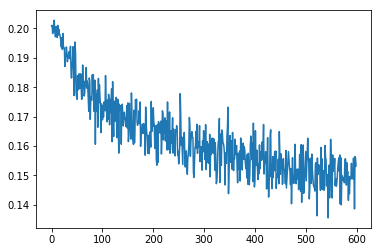

In [0]:
## Result of angle distance
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
def to_extracted_features(normalized_feature_dict, model):
  # doc_id is app_id for application, pared for grants.
  sorted_keys = sorted(normalized_feature_dict.keys())

  input_tensors = tf.convert_to_tensor(
      np.array([ normalized_feature_dict[k] for k in sorted_keys ]),
      dtype=tf.float32)
  extracted_features = model.frwrd_pass(input_tensors).numpy()
  return pd.DataFrame({ 
    'doc_id':sorted_keys, 'extracted_feature':[ v/np.linalg.norm(v) for v in extracted_features ]})

In [0]:
def sort_similarity_by_value(sim_dict, app_id):
    '''
    input:
        sim_dict: similary dictionary
        app_id: target application id
    return:
        [(parsed1, sim1), (parsed2, sim2), ...] sorted by similarities
    '''
    return [(parsed, sim_dict[app_id][parsed]) for parsed in sorted(sim_dict[app_id], key=sim_dict[app_id].get)]
  
  
def get_cited_grants(citations_info_target, app_id):
    '''
    input:
        citations_info_target: DataFrame of citation relationships
        app_id: target application id
    return:
        {parsed1, parsed2, ...} that are cited to reject app_id
    '''
    return set(citations_info_target[citations_info_target['app_id'] == app_id]['parsed'])
  
def make_uncited_grants_for_app_id(sim_dict, citations_info_target, app_id, sidx, eidx, num, shuffle=True):
    '''
    input:
        sim_dict: 
        citations_info_target:
        app_id: target application id
        sidx: start index to slice the sorted (parsed, sim) list
        eidx: end index to slice the sorted (parsed, sim) list
        num: number of grants that will be returned
    return:
        [parsed_1, parsed_2, ..., parsed_num] that are NOT cited to reject app_id
    '''
    sorted_grants_list = sort_similarity_by_value(sim_dict, app_id)
    sorted_grants_list = sorted_grants_list[sidx:eidx]
    if shuffle:
        random.shuffle(sorted_grants_list)
    
    cited_grants = get_cited_grants(citations_info_target, app_id)
    uncited_grants = []
    
    idx = 0
    while len(uncited_grants) != num:
        grant_id, _ = sorted_grants_list[idx]
        if not grant_id in cited_grants:
            uncited_grants.append(grant_id)
        idx += 1
    
    return uncited_grants  

In [0]:
import collections

def calc_all_ranks(all_app_ids, sim_dic):
  all_ranks = []

  for app_id in all_app_ids:
      cited_grants = get_cited_grants(citations_info_target, app_id)
      sorted_kv = reversed(sort_similarity_by_value(sim_dic, app_id))  # higher score, similar patent

      idx = 1
      for k,v in sorted_kv:
          if k in cited_grants:
              all_ranks.append(idx)
          idx += 1
  return all_ranks

def calc_all_ranks_counter(all_app_ids, sim_dic):
  return collections.Counter(calc_all_ranks(all_app_ids, sim_dic))

In [0]:
test_extracted_features_df = to_extracted_features(test_normalized_feature_dict_3000, model)
grants_extracted_features_df = to_extracted_features(grants_normalized_feature_dict_6000, model)

In [0]:
# angle distance

def create_sim_dict(test_extracted_df, grants_extracted_df):
  return {
    app_id:{# parsed:np.sum(test_f*grants_f)
            parsed:math.pi - np.arccos(np.sum(test_f*grants_f))
            for parsed, grants_f 
            in zip(grants_extracted_df['doc_id'], grants_extracted_df['extracted_feature']) } 
    for app_id, test_f 
    in zip(test_extracted_df['doc_id'], test_extracted_df['extracted_feature'])
  }

In [0]:
## Result of angle distance
%%time

sim_dict_by_extracted = create_sim_dict(test_extracted_features_df, grants_extracted_features_df)
counter = calc_all_ranks_counter(test_extracted_features_df['doc_id'], sim_dict_by_extracted)
print(counter)

Counter({1: 776, 2: 281, 3: 181, 4: 117, 5: 107, 7: 81, 6: 81, 8: 56, 11: 53, 9: 53, 10: 45, 13: 45, 12: 45, 14: 42, 16: 39, 20: 38, 15: 38, 18: 31, 21: 29, 17: 27, 19: 27, 23: 24, 22: 22, 31: 21, 24: 19, 25: 18, 28: 18, 29: 17, 43: 16, 35: 15, 26: 15, 32: 14, 33: 13, 27: 13, 39: 13, 36: 13, 51: 12, 41: 12, 42: 11, 34: 11, 55: 10, 57: 10, 50: 10, 60: 10, 100: 10, 30: 10, 65: 9, 59: 9, 45: 9, 61: 9, 56: 9, 94: 9, 40: 9, 75: 9, 49: 8, 37: 8, 46: 8, 62: 8, 48: 8, 44: 8, 38: 8, 81: 7, 74: 7, 69: 7, 66: 7, 96: 6, 47: 6, 77: 6, 68: 6, 53: 6, 129: 6, 79: 6, 186: 6, 52: 6, 98: 5, 108: 5, 118: 5, 80: 5, 142: 5, 71: 5, 76: 5, 99: 5, 63: 5, 121: 5, 95: 5, 86: 5, 141: 4, 97: 4, 106: 4, 177: 4, 174: 4, 160: 4, 54: 4, 89: 4, 82: 4, 90: 4, 78: 4, 72: 4, 135: 4, 119: 4, 123: 4, 128: 4, 91: 4, 109: 4, 101: 4, 146: 4, 88: 4, 64: 4, 112: 3, 229: 3, 84: 3, 246: 3, 264: 3, 222: 3, 185: 3, 114: 3, 110: 3, 87: 3, 155: 3, 145: 3, 231: 3, 205: 3, 107: 3, 92: 3, 111: 3, 178: 3, 244: 3, 83: 3, 1454: 2, 353: 2, 1

In [0]:
similarities = [ list(sim_dict_by_extracted[doc_id].values()) for doc_id in test_extracted_features_df['doc_id']]
sim_arr = np.array(similarities)
sim_arr.shape

(3000, 6440)

In [0]:
def test_label(app_id, grant, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grant["parsed"] ]

In [0]:
%%time

ranking = []

for num in range(len(similarities)):

  app_id = test_extracted_features_df['doc_id'][num]
  label = pd.Series(test_label(app_id, grants, citations_info_target))
    
  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(similarities[num], reverse=True).index(similarities[num][cited_index])
  ranking.append(rank)

CPU times: user 1min 12s, sys: 22.5 ms, total: 1min 12s
Wall time: 1min 12s


In [0]:
%%time

ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

CPU times: user 1min 24s, sys: 22.7 ms, total: 1min 25s
Wall time: 1min 25s


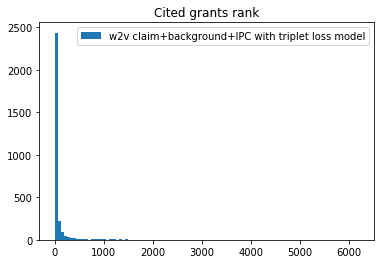

In [0]:
import matplotlib.pyplot as plt

plt.hist(ranking, alpha=1, bins=100, label="w2v claim+background+IPC with triplet loss model")
plt.title("Cited grants rank")
plt.legend()
plt.show()

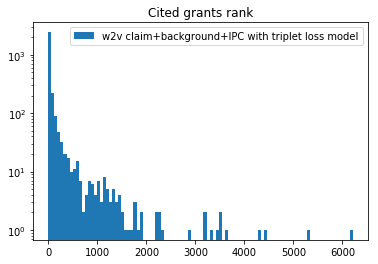

In [0]:
import matplotlib.pyplot as plt

plt.hist(ranking, alpha=1, bins=100, label="w2v claim+background+IPC with triplet loss model")
plt.title("Cited grants rank")
plt.yscale('log')
plt.legend()
plt.show()

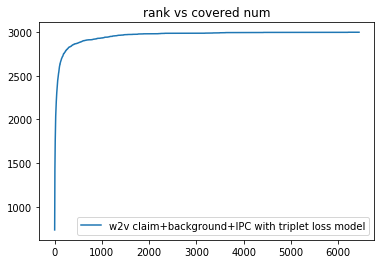

In [0]:
plt.plot(range(len(grants)), positive_counts, label="w2v claim+background+IPC with triplet loss model")
plt.title("rank vs covered num")
plt.legend()
plt.show()

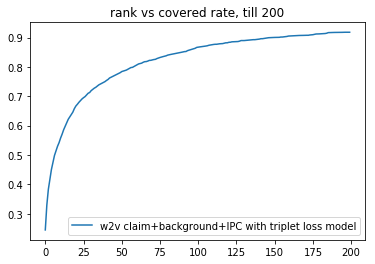

In [0]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200], label="w2v claim+background+IPC with triplet loss model")
plt.title("rank vs covered rate, till 200")
plt.legend()
plt.show()

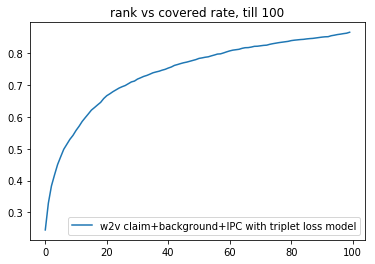

In [0]:
plt.plot(range(100), (np.array(positive_counts)/len(ranking))[0:100], label="w2v claim+background+IPC with triplet loss model")
plt.title("rank vs covered rate, till 100")
plt.legend()
plt.show()

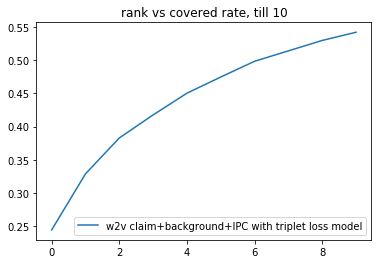

In [0]:
plt.plot(range(10), (np.array(positive_counts)/len(ranking))[0:10], label="w2v claim+background+IPC with triplet loss model")
plt.title("rank vs covered rate, till 10")
plt.legend()
plt.show()

In [0]:
print("w2v claim+background+IPC with triplet loss top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with triplet loss top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with triplet loss top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with triplet loss top 10   : 0.558
w2v claim+background+IPC with triplet loss top 100  : 0.868
w2v claim+background+IPC with triplet loss top 200  : 0.919



BERT pair prediction top 10    : 0.397

BERT pair prediction top 100  : 0.814

BERT pair prediction top 200  : 0.905

cosine distance


w2v claim+background+IPC with triplet loss top 10   : 0.554

w2v claim+background+IPC with triplet loss top 100  : 0.849

w2v claim+background+IPC with triplet loss top 200  : 0.906